In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#ADD STRIKES!

In [3]:
import os
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm

import matplotlib.pyplot as plt
import multiprocessing as mp

pd.set_option('display.max_rows', 100)

store_stocks_dict = dict()
store_indexes_dict = dict()

## Loading and utils

In [4]:
def update_stocks():
    os.system("rm mstcgl*.zip")
    #os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/ciagle/mstock/mstcgl.zip")
    os.system("rm -rf data/*")
    os.system("unzip mstcgl.zip -d data/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_data("WIG20").index.max().strftime(format = "%Y-%m-%d")}')


def update_indexes():
    os.system("rm mstzgr*.zip")
    #os.system("rm mstzgr.zip -d data_for/")
    os.system("wget https://moja.info.bossa.pl/pub/indzagr/mstock/mstzgr.zip")
    os.system("rm -rf data_for/*")
    os.system("unzip mstzgr.zip -d data_for/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_index("NIKKEI").index.max().strftime(format = "%Y-%m-%d")}')


def prepare_data(paper):

    if 'mst' in paper:
        paper = str(paper).rstrip('.mst')

    try:
        df = store_stocks_dict[paper].copy()
    except:
        df = pd.read_csv(f'data/{paper}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_stocks_dict[paper] = df.copy()

    return df


def prepare_index(indeks):

    if 'mst' in indeks:
        indeks = str(indeks).rstrip('.mst')

    try:
        df = store_indexes_dict[indeks].copy()
    except:
        df = pd.read_csv(f'data_for/{indeks}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_indexes_dict[indeks] = df.copy()

    return df

In [5]:
update_indexes()

Updated 2020-04-12, max actual date:     2020-04-10


In [6]:
update_stocks()

Updated 2020-04-12, max actual date:     2020-04-09


In [5]:
all_stocks = os.listdir('data/')
all_indekses = os.listdir('data_for/')
print(
    f'no of all available stock: {len(all_stocks)} and indexes: {len(all_indekses)}'
)

no of all available stock: 1957 and indexes: 23


In [6]:
before_crises = '2020-02-15'
big_drop_date = '2020-03-12'
today = str(date.today())

## Single plot

### Plot code

In [107]:
def plot_paper(papier, plot_range_min, plot_range_max):
    df = prepare_data(papier)

    plot_df = df.loc[(df.index >= plot_range_min) & 
                     (df.index <= plot_range_max),:].copy()
    if not plot_df.shape[0]:
        return 'Nothing to show!'

    spread = (plot_df.loc[:,'CLOSE'].max() - plot_df.loc[:,'CLOSE'].min()) / 14

    plot_df.loc[:,'CLOSE_diff'] = ((plot_df.loc[:,'CLOSE']
                                                - plot_df.loc[:,'CLOSE'].shift(1))
                                                / plot_df.loc[:,'CLOSE'].shift(1)) * 100

    plot_df_bar = ((plot_df.loc[:,'VOL'] - plot_df.loc[:,'VOL'].mean()) 
               / plot_df.loc[:,'VOL'].std() * spread)
    plot_df_bar = plot_df_bar + abs(plot_df_bar.min())
    plot_bar_bottom = plot_df.loc[:,'CLOSE'].min() - plot_df_bar.max()

    plot_df_vol_close = (plot_df.loc[:,'VOL'].rolling(3).mean() * 
             plot_df.loc[:,'CLOSE_diff'].rolling(3).mean())
    plot_df_vol_close = ((plot_df_vol_close - plot_df_vol_close.mean()) 
                         / plot_df_vol_close.std()) * spread
    plot_df_vol_close = plot_df_vol_close + (plot_bar_bottom - plot_df_vol_close.max())
    
    bottom_date = plot_df.loc[plot_df.loc[:,'CLOSE'] 
                              == plot_df.loc[:,'CLOSE'].min()].index.strftime('')[0]


    plt.figure(figsize=(20,10))
    plt.plot(plot_df.loc[:,'CLOSE'])
    plt.plot(plot_df_vol_close)

    plt.bar(plot_df_bar.index, 
            plot_df_bar.values,
           bottom = plot_bar_bottom)

    plt.hlines(plot_df.loc[:,'CLOSE'].min(), 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='blue')
#     plt.hlines(plot_df.loc[plot_df.index >= bottom_date,'CLOSE'].max(), 
#                plot_range_min, plot_range_max, 
#                linestyles='--', 
#                colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.2, 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.1, 
           plot_range_min, plot_range_max, 
           linestyles='--', 
           colors='orange')
    
    plt.xticks(rotation=15)
    plt.legend([df.TICKER[0],
                'volumen * close',
               'minimum',
               'min + 20%',
               'volumen'])
    plt.show()
    
def prepare_stats_forone(papier, before_crises, big_drop_date):
    
    df = prepare_data(papier)
    df = df.loc[df.index >= '2020-01-01',:]
    
    current = df.tail(1).CLOSE

    
    data_max_before_crisis = df.loc[(df.index <= before_crises) &
                                 (df.index >= '2020-01-01'),"CLOSE"].max()
    data_max_after_drop = df.loc[df.index >= big_drop_date,"CLOSE"].max()
    data_min_after_max = df.loc[df.index >= 
                                df.loc[df.loc[:,'CLOSE'] == data_max_after_drop].index[0], 
                                'CLOSE']
    data_crises_min = df.loc[(df.index <= big_drop_date) & 
           (df.index >= before_crises),"CLOSE"].min()
    
    #dates
    date_max_after_drop = df.loc[df.loc[:,'CLOSE'] == data_max_after_drop,:].index
    
    return (current, data_max_before_crisis, data_crises_min, data_max_after_drop, data_min_after_max,
           date_max_after_drop)

In [108]:
watch = ['PZU', 
         'KGHM', 
         'ASSECOSEE', 
         'NORTCOAST', 
         'CDPROJEKT', 
         'VOTUM', 
         'NEWAG', 
         'KRUSZWICA', 
         'INTERAOLT', 
         'PLAY', 
         'ARCHICOM', 
         'LPP', 
         'ARCTIC', 
         'PGNIG',
        'TAURONPE', 
         'PKOBP', 
         'JSW']

watch_af = ['KGHM',
            'KRUK', 
            'PKNORLEN',
            'ENEA',
            'MBANK', 
            'PKOBP', 
            'WIELTON']

### Just plot

In [266]:
[a for a in all_stocks if 'MAK' in a]

['REMAK.mst', 'MAKARONPL.mst', 'QUMAK.mst']

In [267]:
papier = 'MAKARONPL'

In [268]:
#plot_paper(papier,'2008-07-15','2008-11-15')

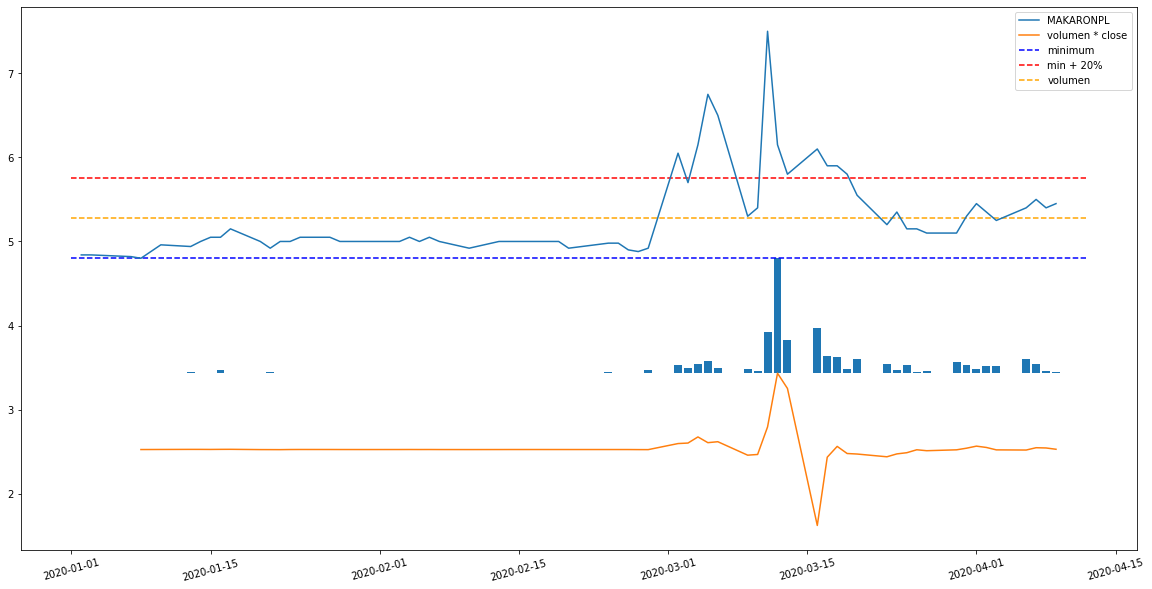

In [269]:
plot_paper(papier,'2020-01-01', str(date.today()))

In [270]:
(current,
data_max_before_crisis,
 data_crises_min,
 data_max_after_drop,
 data_min_after_max,
date_max_after_drop) = prepare_stats_forone(papier, before_crises, big_drop_date)

In [271]:
print(f'Paper: {papier}, currently at {current[0]}, with potential \
{round(data_max_before_crisis*100/current[0]-100, 2)}% to top')
print(f'Max before crisis: {data_max_before_crisis}')
print(f'Crisis bottom: {data_crises_min}')
print(f'Max after crisis drop: {data_max_after_drop}, at {date_max_after_drop[0]}')
print(f'Stats after Max: {data_min_after_max.values}')

Paper: MAKARONPL, currently at 5.45, with potential -5.5% to top
Max before crisis: 5.15
Crisis bottom: 4.88
Max after crisis drop: 6.15, at 2020-03-04 00:00:00
Stats after Max: [6.15 6.75 6.5  5.3  5.4  7.5  6.15 5.8  6.1  5.9  5.9  5.8  5.55 5.2
 5.35 5.15 5.15 5.1  5.1  5.3  5.45 5.35 5.25 5.4  5.5  5.4  5.45]


## Skaner

In [7]:
before_crisis = '2020-02-17'
top_bottom = '2020-03-12'
new_year = '2020-01-01'
last_y_quarter = '2019-10-01'
last_y_mid = '2019-06-03'

df_cols = [
    'ticker', 'current', 'before_crisis', 'last_y_q', 'last_y_mid',
    'crisis_bottom', 'max_after_crisis', 'max_before_crisis'
]

### All papers

In [8]:
skaner_df = pd.DataFrame(columns=df_cols)
for w in tqdm(all_stocks):
    
    df = prepare_data(w)
   
    skaner_df = pd.concat([skaner_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

100%|██████████| 1957/1957 [00:19<00:00, 99.85it/s] 


In [9]:
skaner_df.loc[:,'growth_quarter'] = round(skaner_df.loc[:,'before_crisis'] * 100 / skaner_df.loc[:,'last_y_q'] - 100, 2)
skaner_df.loc[:,'growth_mid'] = round(skaner_df.loc[:,'last_y_q'] * 100 / skaner_df.loc[:,'last_y_mid'] - 100, 2)
skaner_df.loc[:,'growth_from_crisis'] = round(skaner_df.loc[:,'max_after_crisis'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_potential'] = round((skaner_df.loc[:,'max_before_crisis'] * 100) / skaner_df.loc[:,'current'] - 100, 2)
skaner_df.loc[:,'drop_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'max_before_crisis'] - 100, 2)

In [10]:
skaner_df_see = skaner_df.loc[
    (skaner_df.growth_quarter > 0) 
        #& (skaner_df.growth_mid > 0) 
        #& (skaner_df.drop_current < 0) 
        & (skaner_df.growth_current > 10)
                              ,:].sort_values('drop_current', ascending=True)

In [11]:
skaner_df_see = skaner_df_see.loc[
    skaner_df_see.ticker.apply(lambda x: 
                               False if ('RCFL' in x) 
                               | ('INTLGLD' in x) 
                               | ('RCFS' in x)
                               | ('INTL' in x)
                               | ('INTS' in x)
                               | ('RCTL' in x)
                               | ('BETA' in x)
                               | ('RCL' in x) else True).values,]

In [12]:
skaner_df_see.shape

(178, 14)

In [13]:
skaner_df_see.tail(100)

,ticker,current,before_crisis,last_y_q,last_y_mid,crisis_bottom,max_after_crisis,max_before_crisis,growth_quarter,growth_mid,growth_from_crisis,growth_current,growth_potential,drop_current
0,WIG-ESG,7546.340,9983.760,9797.230,NaN,6337.720,7546.340,10251.600,1.90,NaN,19.07,19.07,35.85,-26.39
0,BENEFIT,748.000,1010.000,700.000,556.000,625.000,750.000,1015.000,44.29,25.90,20.00,19.68,35.70,-26.31
0,KRVITAMIN,4.420,5.200,4.260,5.360,3.700,4.710,5.980,22.07,-20.52,27.30,19.46,35.29,-26.09
0,FERRO,13.500,17.250,13.700,13.900,10.300,13.500,18.250,25.91,-1.44,31.07,31.07,35.19,-26.03
0,RADPOL,1.170,1.455,1.140,1.415,0.940,1.180,1.580,27.63,-19.43,25.53,24.47,35.04,-25.95
0,WIRTUALNA,64.000,84.600,66.800,58.000,47.400,64.000,86.400,26.65,15.17,35.02,35.02,35.00,-25.93
0,OTLOG,5.200,6.450,5.900,7.200,4.500,6.000,7.000,9.32,-18.06,33.33,15.56,34.62,-25.71
0,DECORA,14.900,19.700,17.500,18.100,11.900,16.000,20.000,12.57,-3.31,34.45,25.21,34.23,-25.50
0,ODLEWNIE,3.840,5.100,3.360,3.680,3.220,3.840,5.150,51.79,-8.70,19.25,19.25,34.11,-25.44
0,TORPOL,6.640,8.900,6.880,6.960,5.000,6.900,8.900,29.36,-1.15,38.00,32.80,34.04,-25.39


## Monitoring

In [89]:
to_monitor_list = ['ASBIS', 'UNIMOT',
            'CLNPHARMA', 'SUNEX', 
            'ELKOP', 'ABPL', 
            'MLSYSTEM',
            'AMBRA', 'INTERAOLT', 
            'LENA', 'ARCHICOM', 
            'KREC', 'INTERCARS', 'WIRTUALNA',
            'PLAY', 'MOSTALPLC', 'WIELTON']

In [90]:
df_merged = prepare_data(to_monitor_list[0]).loc[:,['CLOSE', 'TICKER', 'VOL']].copy()
df_merged = df_merged.loc[df_merged.index >= '2020-01-01'].copy()
df_merged.loc[:,'CLOSE'] = ((df_merged.loc[:,'CLOSE'] - df_merged.loc[:,'CLOSE'].mean()) 
                            / df_merged.loc[:,'CLOSE'].std())
df_merged.loc[:,'VOL'] = ((df_merged.loc[:,'VOL'] - df_merged.loc[:,'VOL'].mean()) 
                            / df_merged.loc[:,'VOL'].std())

In [91]:
for a in tqdm(to_monitor_list[1:]):

    df = prepare_data(a)
    df = df.loc[df.index >= '2020-01-01', ['CLOSE', 'TICKER', 'VOL']].copy()
    df.loc[:,'CLOSE'] = ((df.loc[:,'CLOSE'] - df.loc[:,'CLOSE'].mean()) 
                                / df.loc[:,'CLOSE'].std())
    df.loc[:,'VOL'] = ((df.loc[:,'VOL'] - df.loc[:,'VOL'].mean()) 
                                / df.loc[:,'VOL'].std())
        
    df_merged = pd.merge(df_merged, df,
                     left_index=True,
                     right_index=True,
                        how = 'outer')

100%|██████████| 16/16 [00:00<00:00, 79.36it/s]


In [92]:
df_stats = pd.DataFrame()

In [93]:
for t in ['CLOSE', 'VOL']:
    df_merged_limited = df_merged.loc[:, [c for c in df_merged.columns if t in c]]
    df_stats.loc[:,f'{t}_sum'] = df_merged_limited.sum(axis = 1)
    df_stats.loc[:,f'{t}_std'] = df_merged_limited.std(axis = 1)
    df_stats.loc[:,f'{t}_mean'] = df_merged_limited.mean(axis = 1)
    df_stats.loc[:,f'{t}_median'] = df_merged_limited.median(axis = 1)
    df_stats.loc[:,f'{t}_q90'] = df_merged_limited.quantile(0.9,axis = 1)
    df_stats.loc[:,f'{t}_q10'] = df_merged_limited.quantile(0.1,axis = 1)

In [94]:
for n in [5, 20]:
    
    df_stats.loc[:,f'CLOSE_mean_rolling{n}'] = df_stats.loc[:,'CLOSE_mean'].rolling(n).mean()
    df_stats.loc[:,f'VOL_mean_rolling{n}'] = df_stats.loc[:,'VOL_mean'].rolling(n).mean()

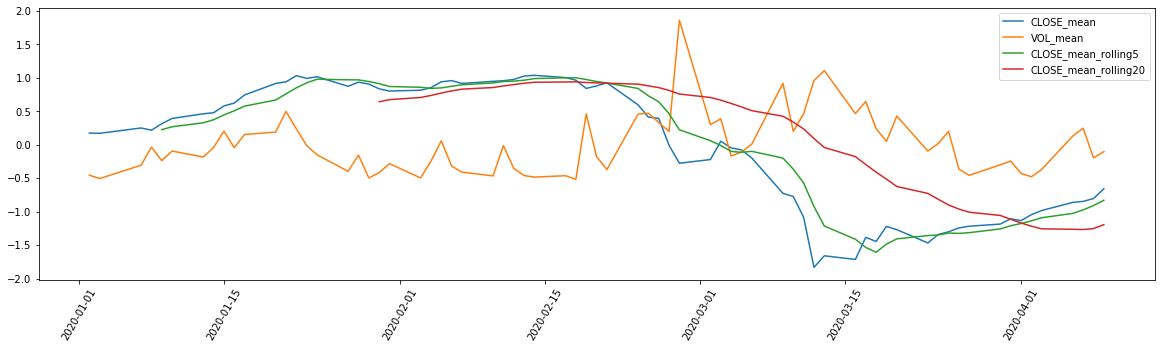

In [95]:
plt.figure(figsize=(20,5))
cols_to_plot = ['CLOSE_mean', 'VOL_mean',
                        'CLOSE_mean_rolling5',
                        'CLOSE_mean_rolling20']
plt.plot(df_stats.loc[:,cols_to_plot])
plt.xticks(rotation=60)
plt.legend(cols_to_plot)

## Model

In [14]:
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.metrics import confusion_matrix

In [15]:
def transform_one_paper_ch(df):
    
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
        
#     df.loc[:,'chng_OPEN1_CLOSE'] = (df.loc[:,'OPEN'].shift(1) * 100 / df.loc[:,'CLOSE']) - 100
#     df.loc[:,'chng_LOW1_CLOSE'] = (df.loc[:,'LOW'].shift(1) * 100 / df.loc[:,'CLOSE']) - 100
#     df.loc[:,'chng_HIGH1_CLOSE'] = (df.loc[:,'HIGH'].shift(1) * 100 / df.loc[:,'CLOSE']) - 100
        
    df.loc[:,'move_strength_abs'] =  abs(df.loc[:,'chng_CLOSE']) * abs(df.loc[:,'chng_VOL'])
    df.loc[:,'move_strength'] =  (df.loc[:,'chng_CLOSE']) * (df.loc[:,'chng_VOL'])
    
    
### COMPARISON SECTION
#are you on losing strike?
#str strike
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        for i in [5,10,20,30,60]:
            df.loc[:,f'comp{i}d_max' + col] = df.loc[:,col].rolling(i).max()
            df.loc[:,f'comp{i}d_max' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_max' + col]) - 100
            
            df.loc[:,f'comp{i}d_min' + col] = df.loc[:,col].rolling(i).min()
            df.loc[:,f'comp{i}d_min' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_min' + col]) - 100
            
            df.loc[:,f'comp{i}d_mean' + col] = df.loc[:,col].rolling(i).mean()
            df.loc[:,f'comp{i}d_mean' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_mean' + col]) - 100
            
            df.loc[:,f'comp{i}d_std' + col] = df.loc[:,col].rolling(i).std()
            df.loc[:,f'comp{i}d_std' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_std' + col]) - 100
            
    
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        cols = [f'comp{i}d_max' + col for i in [5,10,20,30,60]]
        df.loc[:,'all_higher_f'] = (df[cols] > 0).sum(axis = 1)
        df.loc[:,'all_higher_cat'] = (df[cols] > 0).astype(str).sum(axis = 1)
        
        cols = [f'comp{i}d_min' + col for i in [5,10,20,30,60]]
        df.loc[:,'all_lower_f'] = (df[cols] < 0).sum(axis = 1)
        df.loc[:,'all_lower_cat'] = (df[cols] < 0).astype(str).sum(axis = 1)
    
            
### FUTURE SECTION ###

#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 0
    
    #df.loc[:, 'fut_OPEN_CLOSE_chng'] = (df.loc[:, 'OPEN'].shift(-1) * 100 / df.loc[:, 'CLOSE']) - 100
    
#     df.loc[:, 'chng_rel_OPEN'] = np.nan
#     df.loc[df.loc[:, 'HIGH'] > df.loc[:, 'OPEN'] * 1.01,'chng_rel_OPEN'] = 1
#     df.loc[df.loc[:, 'HIGH'] <= df.loc[:, 'OPEN'] * 1.01, 'chng_rel_OPEN'] = 0
    
#     df.loc[df.loc[:, 'OPEN'] < df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 1
#     df.loc[df.loc[:, 'OPEN'] >= df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 0


### DIFFS SECTION ###
    df.loc[:,'diff_LOW_HIGH'] = (df.loc[:,'HIGH'] - df.loc[:,'LOW']) / df.loc[:,'HIGH']
    df.loc[:,'diff_OPEN_CLOSE'] = (df.loc[:,'OPEN'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_LOW_CLOSE'] = (df.loc[:,'CLOSE'] - df.loc[:,'LOW']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_HIGH_CLOSE'] = (df.loc[:,'HIGH'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    
    
### HISTORIC SECTION ###

    for a in [c for c in df.columns if ('diff_' in c) | ('chng' in c) | ('chng_' in c)]:
        for i in [1, 2, 3]:
            df.loc[:,f'hist{i}_' + a] = df.loc[:,a].shift(i)

### GET SOME MEANS ###
#Trye min and maxes and some std?
    for b in [c for c in df.columns if (('chng_' in c) 
                                        | ('move_' in c) 
                                        | ('diff_' in c)
                                       | ('same_' in c)) & ('hist' not in c)]:
        for g in [2, 3, 5, 10, 20]:
            df.loc[:,f'roll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
            df.loc[:,f'roll{g}min_' + b] = df.loc[:,b].rolling(g).min()
            df.loc[:,f'roll{g}max_' + b] = df.loc[:,b].rolling(g).max()
            #df.loc[:,f'roll{g}max_' + b] = df.loc[:,b].rolling(g).std()

### TARGET SECTION ###
#pick one the of the available sections

### HIGHER HIGH ###
#     df.loc[df.loc[:, 'HIGH'].shift(-1) > df.loc[:, 'HIGH'],'target'] = 1
#     df.loc[df.loc[:, 'HIGH'].shift(-1) <= df.loc[:, 'HIGH'],'target'] = 0

### LOWER LOW ###
#     df.loc[df.loc[:, 'LOW'].shift(-1) < df.loc[:, 'LOW'],'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) >= df.loc[:, 'LOW'],'target'] = 0
    
### HIGHER OPENING ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'target'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'target'] = 0
    
# ### HIGHER CLOSING THAN OPENING ###
    df.loc[df.loc[:, 'CLOSE'].shift(-1) > df.loc[:, 'OPEN'].shift(-1),'target'] = 1
    df.loc[df.loc[:, 'CLOSE'].shift(-1) <= df.loc[:, 'OPEN'].shift(-1),'target'] = 0
    
    return df

def transform_one_index(df):
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
    return df

In [16]:
df_merged = pd.DataFrame()

for p in tqdm(skaner_df_see.ticker.values):
    
    df = prepare_data(p)
        
    df = transform_one_paper_ch(df) 
    df = df.dropna()
    
    df_merged = pd.concat([df_merged, df])
    del df

100%|██████████| 178/178 [05:25<00:00,  1.83s/it]


In [17]:
df_indexes_merged = pd.DataFrame()

for p in tqdm(all_indekses):
    
    df = prepare_index(p)
        
    df = transform_one_index(df) 
    #df = df.dropna()
    
    df_indexes_merged = pd.concat([df_indexes_merged, df])
    del df

100%|██████████| 23/23 [00:01<00:00, 22.59it/s]


In [18]:
df_indexes_merged = df_indexes_merged.pivot_table(index='DTYYYYMMDD', columns='TICKER', values='chng_CLOSE')
df_indexes_merged = df_indexes_merged.agg(['mean', 'max', 'min', 'std'], axis = 1)
df_indexes_merged = df_indexes_merged.add_prefix('foreign_stocks_')

df_merged = df_merged.merge(df_indexes_merged, left_index=True, right_index=True, how = 'left')

In [19]:
train_cols = [c for c in df_merged.columns if ('chng' in c) | ('move' in c) 
              | ('comp' in c) | ('fut' in c) | ('diff' in c) | ('same' in c)]

train_cols = train_cols + list(df_indexes_merged.columns)

train_cols = ['all_lower_cat', 'all_higher_cat', 'all_lower_f', 'all_higher_f'] + train_cols

In [20]:
#train_cols = train_cols_limited

df = df_merged.copy()

In [21]:
cut_date = '2020-03-13'
train_data = df.loc[df.index < cut_date,train_cols]
eval_data = df.loc[df.index >= cut_date,train_cols]
train_labels = df.loc[df.index < cut_date,'target'].values
eval_labels = df.loc[df.index >= cut_date,'target'].values

In [26]:
# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=10000,
                           learning_rate=0.02,
                           depth=4,
                          thread_count=4,
                          eval_metric='AUC',
                          task_type='CPU')

# # # Initialize CatBoostRegressor
# model = CatBoostRegressor(iterations=2000,
#                            learning_rate=0.05,
#                            depth=3,
#                           thread_count=4,
#                           eval_metric='RMSE')

In [27]:
model.fit(train_data, train_labels, cat_features=[0, 1],
          eval_set=(eval_data[:-1], eval_labels[:-1]),
         early_stopping_rounds=100, use_best_model=True)

0:	test: 0.5312182	best: 0.5312182 (0)	total: 336ms	remaining: 55m 55s
1:	test: 0.5324225	best: 0.5324225 (1)	total: 686ms	remaining: 57m 9s
2:	test: 0.5255736	best: 0.5324225 (1)	total: 1s	remaining: 55m 47s
3:	test: 0.5351327	best: 0.5351327 (3)	total: 1.34s	remaining: 55m 42s
4:	test: 0.5339187	best: 0.5351327 (3)	total: 1.69s	remaining: 56m 15s
5:	test: 0.5355826	best: 0.5355826 (5)	total: 2s	remaining: 55m 32s
6:	test: 0.5347593	best: 0.5355826 (5)	total: 2.33s	remaining: 55m 24s
7:	test: 0.5334474	best: 0.5355826 (5)	total: 2.67s	remaining: 55m 37s
8:	test: 0.5333400	best: 0.5355826 (5)	total: 3.07s	remaining: 56m 46s
9:	test: 0.5345208	best: 0.5355826 (5)	total: 3.46s	remaining: 57m 36s
10:	test: 0.5326483	best: 0.5355826 (5)	total: 3.85s	remaining: 58m 19s
11:	test: 0.5296411	best: 0.5355826 (5)	total: 4.17s	remaining: 57m 48s
12:	test: 0.5298567	best: 0.5355826 (5)	total: 4.46s	remaining: 57m 7s
13:	test: 0.5274743	best: 0.5355826 (5)	total: 4.8s	remaining: 57m 5s
14:	test: 0.

115:	test: 0.5385424	best: 0.5386560 (114)	total: 41.4s	remaining: 58m 44s
116:	test: 0.5387179	best: 0.5387179 (116)	total: 41.9s	remaining: 58m 56s
117:	test: 0.5389061	best: 0.5389061 (117)	total: 42.3s	remaining: 59m
118:	test: 0.5387656	best: 0.5389061 (117)	total: 42.7s	remaining: 59m 1s
119:	test: 0.5387738	best: 0.5389061 (117)	total: 43s	remaining: 59m 3s
120:	test: 0.5387472	best: 0.5389061 (117)	total: 43.4s	remaining: 59m 3s
121:	test: 0.5388139	best: 0.5389061 (117)	total: 43.8s	remaining: 59m 3s
122:	test: 0.5391195	best: 0.5391195 (122)	total: 44.1s	remaining: 59m 1s
123:	test: 0.5391107	best: 0.5391195 (122)	total: 44.4s	remaining: 58m 58s
124:	test: 0.5392084	best: 0.5392084 (124)	total: 44.8s	remaining: 58m 55s
125:	test: 0.5394048	best: 0.5394048 (125)	total: 45.2s	remaining: 59m 1s
126:	test: 0.5409950	best: 0.5409950 (126)	total: 45.6s	remaining: 59m 2s
127:	test: 0.5418421	best: 0.5418421 (127)	total: 45.9s	remaining: 59m 3s
128:	test: 0.5421743	best: 0.5421743 (1

225:	test: 0.5580572	best: 0.5580572 (225)	total: 1m 25s	remaining: 1h 1m 40s
226:	test: 0.5578508	best: 0.5580572 (225)	total: 1m 25s	remaining: 1h 1m 41s
227:	test: 0.5578320	best: 0.5580572 (225)	total: 1m 26s	remaining: 1h 1m 42s
228:	test: 0.5579087	best: 0.5580572 (225)	total: 1m 26s	remaining: 1h 1m 43s
229:	test: 0.5584999	best: 0.5584999 (229)	total: 1m 27s	remaining: 1h 1m 42s
230:	test: 0.5590352	best: 0.5590352 (230)	total: 1m 27s	remaining: 1h 1m 41s
231:	test: 0.5589681	best: 0.5590352 (230)	total: 1m 27s	remaining: 1h 1m 41s
232:	test: 0.5596508	best: 0.5596508 (232)	total: 1m 28s	remaining: 1h 1m 38s
233:	test: 0.5596452	best: 0.5596508 (232)	total: 1m 28s	remaining: 1h 1m 37s
234:	test: 0.5596615	best: 0.5596615 (234)	total: 1m 28s	remaining: 1h 1m 36s
235:	test: 0.5595737	best: 0.5596615 (234)	total: 1m 29s	remaining: 1h 1m 35s
236:	test: 0.5595697	best: 0.5596615 (234)	total: 1m 29s	remaining: 1h 1m 33s
237:	test: 0.5597886	best: 0.5597886 (237)	total: 1m 30s	remaini

331:	test: 0.5632175	best: 0.5632175 (331)	total: 2m 6s	remaining: 1h 1m 20s
332:	test: 0.5632481	best: 0.5632481 (332)	total: 2m 6s	remaining: 1h 1m 21s
333:	test: 0.5633893	best: 0.5633893 (333)	total: 2m 7s	remaining: 1h 1m 20s
334:	test: 0.5651657	best: 0.5651657 (334)	total: 2m 7s	remaining: 1h 1m 18s
335:	test: 0.5654852	best: 0.5654852 (335)	total: 2m 7s	remaining: 1h 1m 19s
336:	test: 0.5655645	best: 0.5655645 (336)	total: 2m 8s	remaining: 1h 1m 18s
337:	test: 0.5660127	best: 0.5660127 (337)	total: 2m 8s	remaining: 1h 1m 16s
338:	test: 0.5658771	best: 0.5660127 (337)	total: 2m 8s	remaining: 1h 1m 15s
339:	test: 0.5659246	best: 0.5660127 (337)	total: 2m 9s	remaining: 1h 1m 17s
340:	test: 0.5659280	best: 0.5660127 (337)	total: 2m 9s	remaining: 1h 1m 18s
341:	test: 0.5660109	best: 0.5660127 (337)	total: 2m 10s	remaining: 1h 1m 17s
342:	test: 0.5664643	best: 0.5664643 (342)	total: 2m 10s	remaining: 1h 1m 16s
343:	test: 0.5665579	best: 0.5665579 (343)	total: 2m 10s	remaining: 1h 1m 

440:	test: 0.5746996	best: 0.5747353 (436)	total: 2m 47s	remaining: 1h 40s
441:	test: 0.5746937	best: 0.5747353 (436)	total: 2m 48s	remaining: 1h 41s
442:	test: 0.5746738	best: 0.5747353 (436)	total: 2m 48s	remaining: 1h 39s
443:	test: 0.5746579	best: 0.5747353 (436)	total: 2m 49s	remaining: 1h 38s
444:	test: 0.5746775	best: 0.5747353 (436)	total: 2m 49s	remaining: 1h 37s
445:	test: 0.5752219	best: 0.5752219 (445)	total: 2m 49s	remaining: 1h 35s
446:	test: 0.5751629	best: 0.5752219 (445)	total: 2m 50s	remaining: 1h 34s
447:	test: 0.5751685	best: 0.5752219 (445)	total: 2m 50s	remaining: 1h 32s
448:	test: 0.5751600	best: 0.5752219 (445)	total: 2m 50s	remaining: 1h 31s
449:	test: 0.5750593	best: 0.5752219 (445)	total: 2m 51s	remaining: 1h 33s
450:	test: 0.5753314	best: 0.5753314 (450)	total: 2m 51s	remaining: 1h 32s
451:	test: 0.5752982	best: 0.5753314 (450)	total: 2m 51s	remaining: 1h 31s
452:	test: 0.5753812	best: 0.5753812 (452)	total: 2m 52s	remaining: 1h 29s
453:	test: 0.5754235	best

551:	test: 0.5782191	best: 0.5786231 (524)	total: 3m 30s	remaining: 59m 56s
552:	test: 0.5782700	best: 0.5786231 (524)	total: 3m 30s	remaining: 59m 55s
553:	test: 0.5781720	best: 0.5786231 (524)	total: 3m 30s	remaining: 59m 53s
554:	test: 0.5781299	best: 0.5786231 (524)	total: 3m 31s	remaining: 59m 52s
555:	test: 0.5781310	best: 0.5786231 (524)	total: 3m 31s	remaining: 59m 50s
556:	test: 0.5783935	best: 0.5786231 (524)	total: 3m 31s	remaining: 59m 49s
557:	test: 0.5784256	best: 0.5786231 (524)	total: 3m 32s	remaining: 59m 49s
558:	test: 0.5784407	best: 0.5786231 (524)	total: 3m 32s	remaining: 59m 49s
559:	test: 0.5783552	best: 0.5786231 (524)	total: 3m 32s	remaining: 59m 50s
560:	test: 0.5783529	best: 0.5786231 (524)	total: 3m 33s	remaining: 59m 51s
561:	test: 0.5786456	best: 0.5786456 (561)	total: 3m 33s	remaining: 59m 50s
562:	test: 0.5786069	best: 0.5786456 (561)	total: 3m 34s	remaining: 59m 49s
563:	test: 0.5786143	best: 0.5786456 (561)	total: 3m 34s	remaining: 59m 48s
564:	test: 0

660:	test: 0.5836706	best: 0.5836706 (660)	total: 4m 12s	remaining: 59m 25s
661:	test: 0.5842718	best: 0.5842718 (661)	total: 4m 12s	remaining: 59m 24s
662:	test: 0.5843120	best: 0.5843120 (662)	total: 4m 13s	remaining: 59m 24s
663:	test: 0.5842335	best: 0.5843120 (662)	total: 4m 13s	remaining: 59m 25s
664:	test: 0.5842622	best: 0.5843120 (662)	total: 4m 13s	remaining: 59m 25s
665:	test: 0.5843725	best: 0.5843725 (665)	total: 4m 14s	remaining: 59m 24s
666:	test: 0.5844447	best: 0.5844447 (666)	total: 4m 14s	remaining: 59m 22s
667:	test: 0.5844211	best: 0.5844447 (666)	total: 4m 14s	remaining: 59m 22s
668:	test: 0.5845387	best: 0.5845387 (668)	total: 4m 15s	remaining: 59m 22s
669:	test: 0.5845520	best: 0.5845520 (669)	total: 4m 15s	remaining: 59m 21s
670:	test: 0.5844639	best: 0.5845520 (669)	total: 4m 16s	remaining: 59m 20s
671:	test: 0.5844915	best: 0.5845520 (669)	total: 4m 16s	remaining: 59m 20s
672:	test: 0.5845361	best: 0.5845520 (669)	total: 4m 16s	remaining: 59m 19s
673:	test: 0

768:	test: 0.5852778	best: 0.5860150 (699)	total: 4m 50s	remaining: 58m 9s
769:	test: 0.5852830	best: 0.5860150 (699)	total: 4m 51s	remaining: 58m 9s
770:	test: 0.5852527	best: 0.5860150 (699)	total: 4m 51s	remaining: 58m 8s
771:	test: 0.5848214	best: 0.5860150 (699)	total: 4m 51s	remaining: 58m 8s
772:	test: 0.5848332	best: 0.5860150 (699)	total: 4m 52s	remaining: 58m 7s
773:	test: 0.5848218	best: 0.5860150 (699)	total: 4m 52s	remaining: 58m 5s
774:	test: 0.5848203	best: 0.5860150 (699)	total: 4m 52s	remaining: 58m 4s
775:	test: 0.5848141	best: 0.5860150 (699)	total: 4m 53s	remaining: 58m 3s
776:	test: 0.5847341	best: 0.5860150 (699)	total: 4m 53s	remaining: 58m 3s
777:	test: 0.5848185	best: 0.5860150 (699)	total: 4m 53s	remaining: 58m 2s
778:	test: 0.5848458	best: 0.5860150 (699)	total: 4m 54s	remaining: 58m 2s
779:	test: 0.5848189	best: 0.5860150 (699)	total: 4m 54s	remaining: 58m 2s
780:	test: 0.5846504	best: 0.5860150 (699)	total: 4m 54s	remaining: 58m 1s
781:	test: 0.5849313	best

In [24]:
model.get_feature_importance(prettified=True).head(100)

,Feature Id,Importances
0,roll2max_diff_LOW_HIGH,18.097527
1,roll3m_diff_LOW_HIGH,11.603687
2,roll10min_diff_OPEN_CLOSE,10.062624
3,roll20m_diff_OPEN_CLOSE,8.972523
4,roll5max_diff_LOW_CLOSE,6.486249
5,roll20max_diff_LOW_HIGH,5.720635
6,roll3max_diff_LOW_HIGH,5.498080
7,roll5m_diff_LOW_CLOSE,4.627393
8,diff_LOW_HIGH,4.321476
9,roll3max_diff_LOW_CLOSE,4.162857


In [25]:
imp = model.get_feature_importance(prettified=True)
train_cols_limited  = [c for c in train_cols if c in imp.loc[imp.Importances >= 0.01, 'Feature Id'].values]
len(train_cols) - len(train_cols_limited)

288

#### Analysis categorical

In [28]:
preds_class = model.predict(eval_data)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_data)
# Get predicted RawFormulaVal
preds_raw = model.predict(eval_data, prediction_type='RawFormulaVal')

In [29]:
preds = preds_class[:-1].astype(int)

In [243]:
preds = preds_proba[:,1].copy()
preds[preds > 0.63] = 1
preds[preds < 1] = 0
preds = preds[:-1].astype(int)

In [30]:
confusion_matrix(eval_labels[:-1].astype(int), preds)

array([[1797,   36],
       [1403,   77]])

In [31]:
tn, fp, fn, tp = confusion_matrix(eval_labels[:-1].astype(int), preds).ravel()
(tn, fp, fn, tp)

(1797, 36, 1403, 77)

In [32]:
(tn + tp) / (tn + tp + fp + fn)

0.5656504678539088

In [33]:
tp / (tp + fp)

0.6814159292035398

In [34]:
df_res = pd.concat([pd.DataFrame(preds_proba), pd.Series(eval_labels)], axis=1)
df_res.columns = ['zero', 'one', 'true']
df_res.groupby('true').mean()

,zero,one
true,,
0.0,0.626392,0.373608
1.0,0.604034,0.395966


In [35]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(1)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(1)
df_res_grouped = df_res.drop('zero', axis = 1)

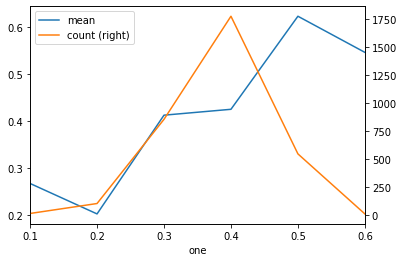

In [36]:
# df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3
# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.55
df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])
df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)
df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

In [37]:
df_res_grouped

,mean,count
one,,
0.1,0.266667,15
0.2,0.201923,104
0.3,0.411902,857
0.4,0.424396,1779
0.5,0.622263,548
0.6,0.545455,11


### Prediction

#### Categorical

In [38]:
eval_data.loc[:,'target'] = eval_labels
eval_data.loc[:,'target'] = eval_data.loc[:,'target'].shift(1)
eval_data.loc[:,'pred_class'] = model.predict(eval_data[train_cols])
eval_data.loc[:,'pred_class'] = eval_data.loc[:,'pred_class'].shift(1)

eval_data.loc[:,'pred_proba'] = model.predict_proba(eval_data[train_cols])[:,1]
eval_data.loc[:,'pred_proba'] = eval_data.loc[:,'pred_proba'].round(1)
eval_data.loc[:,'pred_proba'] = eval_data.loc[:,'pred_proba'].shift(1)

In [44]:
eval_data.groupby('target').mean()['diff_OPEN_CLOSE']

target
0.0   -0.001957
1.0   -0.000673
Name: diff_OPEN_CLOSE, dtype: float64

In [45]:
eval_data.groupby('pred_class').mean()['diff_OPEN_CLOSE']

pred_class
0.0   -0.001545
1.0    0.003178
Name: diff_OPEN_CLOSE, dtype: float64

In [43]:
eval_data.groupby('pred_proba').median()

,all_lower_f,all_higher_f,chng_OPEN,chng_LOW,chng_HIGH,chng_CLOSE,chng_VOL,move_strength_abs,move_strength,comp5d_maxOPEN,...,roll10max_diff_HIGH_CLOSE,roll20m_diff_HIGH_CLOSE,roll20min_diff_HIGH_CLOSE,roll20max_diff_HIGH_CLOSE,foreign_stocks_mean,foreign_stocks_max,foreign_stocks_min,foreign_stocks_std,target,pred_class
pred_proba,,,,,,,,,,,,,,,,,,,,,
0.1,0,0,0.290698,0.000000,0.000000,1.403509,1.744776,104.681887,41.976293,-0.961538,...,0.064356,0.035436,0.0,0.117816,1.105691,4.029356,-1.927911,1.978382,0.0,0.0
0.2,0,0,0.650620,1.015255,0.000000,0.532077,6.791167,166.070836,5.578811,-1.768248,...,0.078947,0.038426,0.0,0.117816,1.648744,6.561077,-3.691061,2.721138,0.0,0.0
0.3,0,0,-0.088073,0.816883,0.000000,1.054618,-2.019580,126.813559,0.000000,-4.986188,...,0.106244,0.038978,0.0,0.133460,3.179108,8.590750,-3.209159,3.092116,0.0,0.0
0.4,0,0,0.303030,0.667780,0.000000,0.298469,-4.789240,98.231702,1.091687,-2.068966,...,0.093939,0.035904,0.0,0.132743,0.725402,5.163030,-3.691061,2.229428,0.0,0.0
0.5,0,0,0.650036,0.000000,-0.406447,-0.677997,-19.443470,117.717024,17.228748,-3.856779,...,0.096154,0.032971,0.0,0.114114,-3.044670,2.023521,-7.034082,2.892963,1.0,0.0
0.6,0,0,0.737101,-0.857183,1.282051,0.990099,1.589131,67.039515,9.790853,-3.691814,...,0.114370,0.034923,0.0,0.124638,-3.044670,2.023521,-7.034082,2.892963,1.0,1.0


#### Prediction for couple of papers

In [46]:
res = pd.DataFrame()

In [47]:
for p in tqdm(skaner_df_see.ticker.values):
    
    df = prepare_data(p)
    df = transform_one_paper_ch(df)
    
    df = df.merge(df_indexes_merged, left_index=True, right_index=True, how = 'left')

    df.loc[:,'pred_class'] = model.predict(df[train_cols])
    df.loc[:,'pred_prob'] = model.predict_proba(df[train_cols])[:,1]
    
    df.loc[:,'fut_OPEN'] = df.loc[:,'OPEN'].shift(-1)
    df.loc[:,'target_OPEN_chng'] = (df.loc[:,'fut_OPEN'] * 100 / df.loc[:,'CLOSE']) - 100
    df.loc[:,'target_HIGH_chng'] = df.loc[:,'chng_HIGH'].shift(-1).copy()
    df.loc[:,'target_CLOSE_chng'] = df.loc[:,'chng_CLOSE'].shift(-1).copy()

    one_res = df.reset_index().loc[:,['DTYYYYMMDD','TICKER','OPEN','LOW','HIGH', 'CLOSE', 
                                      'target', 'pred_class', 'target_OPEN_chng',
                                      'target_HIGH_chng', 'target_CLOSE_chng', 'pred_prob']].tail(15)
    res = pd.concat([res, one_res])

100%|██████████| 178/178 [04:10<00:00,  1.41s/it]


In [54]:
res_see = res.sort_values('pred_prob', ascending=False).copy()

In [55]:
res_see = res_see.drop_duplicates()

In [56]:
res_see.loc[:,'gains'] = res_see.target_CLOSE_chng - res_see.target_OPEN_chng

In [60]:
res_see.loc[res_see.pred_prob > 0.5].groupby('DTYYYYMMDD').mean().mean()

OPEN                 142.075900
LOW                  141.227918
HIGH                 143.888260
CLOSE                143.642024
target                 0.549367
pred_class             1.000000
target_OPEN_chng      -0.716388
target_HIGH_chng       1.935524
target_CLOSE_chng      1.555675
pred_prob              0.519395
gains                  2.272064
dtype: float64

In [434]:
res_see.loc[res_see.TICKER.apply(lambda x: True if x in watch else False),:]

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,target,pred_class,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng,pred_prob,gains
2596,2020-04-08,ARCTIC,4.03,3.95,4.08,4.07,1.0,1.0,0.737101,1.715686,0.000000,0.735078,-0.737101
6372,2020-04-08,CDPROJEKT,295.00,293.00,311.80,308.90,1.0,1.0,7.154419,7.087877,6.506960,0.714212,-0.647459
671,2020-04-08,PLAY,29.80,29.56,33.98,33.40,1.0,1.0,-1.976048,2.118893,1.197605,0.699022,3.173653
883,2020-04-08,ARCHICOM,11.90,11.65,12.00,12.00,0.0,1.0,0.000000,0.000000,0.000000,0.650711,0.000000
3283,2020-04-08,NORTCOAST,14.60,14.55,14.60,14.60,1.0,1.0,0.342466,0.684932,0.000000,0.511319,-0.342466
2321,2020-04-08,ASSECOSEE,28.00,27.30,28.20,27.80,0.0,0.0,0.719424,0.000000,0.000000,0.470361,-0.719424
5753,2020-04-08,KRUSZWICA,52.40,51.00,52.40,52.00,1.0,0.0,1.153846,3.053435,3.846154,0.354254,2.692308
2291,2020-04-08,VOTUM,10.60,10.50,11.50,11.00,0.0,0.0,0.000000,-3.478261,0.000000,0.285524,0.000000
5691,2020-04-08,KGHM,69.16,67.28,69.80,67.50,0.0,0.0,2.222222,-0.429799,2.725926,0.275963,0.503704
1579,2020-04-08,NEWAG,21.70,20.40,21.70,21.20,0.0,0.0,1.415094,-0.921659,-2.358491,0.259302,-3.773585


In [408]:
res_see.loc[res_see.DTYYYYMMDD == '2020-04-08']\
.drop_duplicates().head(100).to_excel('gpw_predictions_20200402.xls')

In [261]:
res_std = res_see.groupby('DTYYYYMMDD')\
.mean()[['target_OPEN_chng', 'target_HIGH_chng', 'target_CLOSE_chng', 'pred_prob']]

In [262]:
res_std = (res_std - res_std.mean()) / res_std.std()

In [265]:
res_std.corr()

,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng,pred_prob
target_OPEN_chng,1.000000,0.747667,0.798805,0.259180
target_HIGH_chng,0.747667,1.000000,0.614235,0.644721
target_CLOSE_chng,0.798805,0.614235,1.000000,0.116755
pred_prob,0.259180,0.644721,0.116755,1.000000


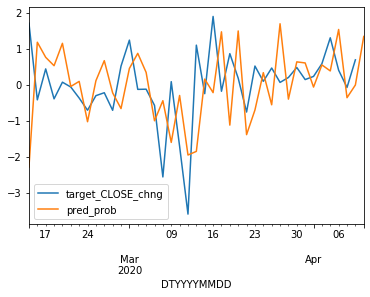

In [264]:
res_std[['target_CLOSE_chng', 'pred_prob']].plot()

In [335]:
df = df_merged.copy()

In [336]:
df.loc[:,'pred_class'] = model.predict(df[train_cols])
df.loc[:,'pred_prob'] = model.predict_proba(df[train_cols])[:,1]

df.loc[:,'fut_OPEN'] = df.loc[:,'OPEN'].shift(-1)
df.loc[:,'target_OPEN_chng'] = (df.loc[:,'fut_OPEN'] * 100 / df.loc[:,'CLOSE']) - 100
df.loc[:,'target_HIGH_chng'] = df.loc[:,'chng_HIGH'].shift(-1).copy()
df.loc[:,'target_CLOSE_chng'] = df.loc[:,'chng_CLOSE'].shift(-1).copy()

In [340]:
res = df.reset_index()

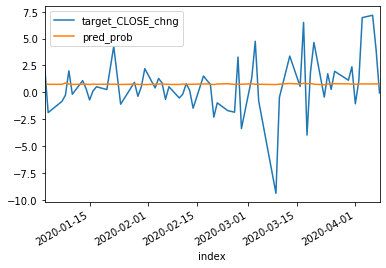

In [354]:
res.loc[(res.loc[:,'index'] > '2020-01-01')
        & (res.pred_prob > 0.7), :].groupby(['index']).mean()[['target_CLOSE_chng', 'pred_prob']].plot()

In [360]:
res.loc[(res.loc[:,'index'] > '2020-01-01')
        & (res.pred_prob > 0.8), :].groupby(['index']).mean()[
    ['target_HIGH_chng','target_CLOSE_chng', 'pred_prob']].median()

target_HIGH_chng     0.202429
target_CLOSE_chng    0.887612
pred_prob            0.833990
dtype: float64

In [355]:
res.sort_values('pred_prob', ascending=False).head(100)

,index,TICKER,OPEN,HIGH,LOW,CLOSE,VOL,OPEN_shifted,chng_OPEN,LOW_shifted,...,target,foreign_stocks_mean,foreign_stocks_max,foreign_stocks_min,pred_class,pred_prob,fut_OPEN,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng
199145,2011-08-11,PGE,17.85,19.250,17.6500,19.250,6.587300e+06,19.150,-6.788512,17.2400,...,1.0,2.857047,5.404341,-0.952958,1.0,0.967548,949.240,4831.116883,-6.512986,9.040890
541326,2020-03-19,WIG20LEV,228.15,248.410,221.7200,248.410,9.736780e+05,234.310,-2.628996,218.3100,...,1.0,1.330692,7.141789,-5.605968,1.0,0.960654,16.400,-93.398011,-4.576659,1.863354
541325,2020-03-19,PGE,3.65,4.036,3.6200,4.036,7.531181e+06,3.520,3.693182,3.3500,...,1.0,1.330692,7.141789,-5.605968,1.0,0.957879,228.150,5552.874133,0.327141,9.721731
199146,2011-08-11,WIG20LEV,949.24,1014.680,863.6800,1014.680,1.683095e+06,1071.960,-11.448188,878.6300,...,1.0,2.857047,5.404341,-0.952958,1.0,0.955207,84.500,-91.672251,-2.526316,4.360465
541313,2020-03-19,CCC,26.00,29.780,25.4000,29.600,2.128518e+06,26.840,-3.129657,24.3000,...,1.0,1.330692,7.141789,-5.605968,1.0,0.954583,3.000,-89.864865,-3.225806,-3.333333
540604,2020-03-13,LOTOS,42.04,45.900,39.8200,44.990,8.754780e+05,40.500,3.802469,39.0000,...,0.0,3.955261,13.908829,-6.080832,1.0,0.954446,1.870,-95.843521,-2.777778,-2.551020
202290,2011-09-15,CDPROJEKT,3.72,3.950,3.7200,3.950,8.404720e+05,3.650,1.917808,3.6200,...,1.0,1.349585,3.271462,-0.332003,1.0,0.952014,2.520,-36.202532,2.325581,4.761905
540955,2020-03-17,CIGAMES,0.41,0.436,0.4000,0.436,2.820567e+06,0.374,9.625668,0.3370,...,1.0,3.179108,13.518576,-3.209159,1.0,0.950566,10.000,2193.577982,-11.297071,0.200401
541403,2020-03-19,WIG30,1631.13,1712.070,1617.3100,1712.070,1.033160e+06,1635.080,-0.241578,1598.5800,...,1.0,1.330692,7.141789,-5.605968,1.0,0.949328,2977.070,73.887166,3.295832,5.038784
540924,2020-03-17,MABION,25.00,31.000,25.0000,31.000,9.760700e+04,20.000,25.000000,18.5000,...,1.0,3.179108,13.518576,-3.209159,1.0,0.947911,4.960,-84.000000,3.488372,6.024096


In [363]:
res.loc[res.pred_prob > 0.7].mean()

OPEN                    694.408521
HIGH                    706.094534
LOW                     691.763361
CLOSE                   705.061505
VOL                  479465.474154
                         ...      
pred_prob                 0.756463
fut_OPEN                361.378365
target_OPEN_chng       3284.682078
target_HIGH_chng          0.329685
target_CLOSE_chng         0.637524
Length: 276, dtype: float64

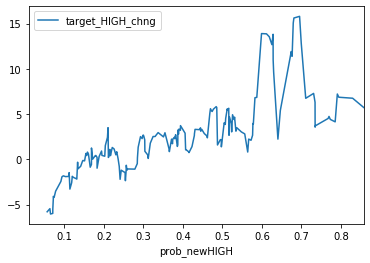

In [162]:
res.loc[:,['target_HIGH_chng', 'prob_newHIGH']]\
.sort_values('prob_newHIGH').set_index('prob_newHIGH').rolling(7).mean().plot()

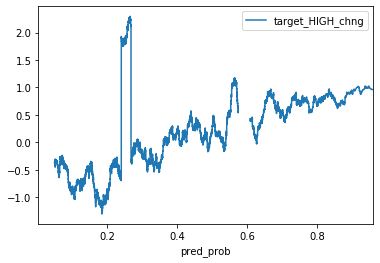

In [375]:
res.loc[res.loc[:,'index'] > '2020-01-01',['target_HIGH_chng', 'pred_prob']]\
.sort_values('pred_prob').set_index('pred_prob').rolling(500).mean().plot()

In [378]:
res.loc[res.loc[:,'index'] > '2020-04-07',:]

,index,TICKER,OPEN,HIGH,LOW,CLOSE,VOL,OPEN_shifted,chng_OPEN,LOW_shifted,...,target,foreign_stocks_mean,foreign_stocks_max,foreign_stocks_min,pred_class,pred_prob,fut_OPEN,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng
543985,2020-04-08,EFEKT,3.16,3.38,2.86,3.24,21180.0,2.58,22.480620,2.54,...,0.0,1.66631,5.106485,-1.166522,0.0,0.403466,25.70,693.209877,-9.507042,-7.692308
543986,2020-04-08,MABION,25.70,25.70,23.40,24.00,75002.0,28.40,-9.507042,25.65,...,0.0,1.66631,5.106485,-1.166522,0.0,0.242316,2.35,-90.208333,-1.673640,-10.638298
543987,2020-04-08,ELBUDOWA,2.35,2.35,1.91,2.10,129473.0,2.35,0.000000,2.18,...,0.0,1.66631,5.106485,-1.166522,0.0,0.113428,33.50,1495.238095,-10.053476,0.240964
543988,2020-04-08,CCC,33.50,33.64,31.50,33.28,521253.0,35.40,-5.367232,33.20,...,1.0,1.66631,5.106485,-1.166522,1.0,0.599440,2.94,-91.165865,-2.000000,-5.172414
543989,2020-04-08,SOLAR,2.94,2.94,2.65,2.75,10255.0,2.59,13.513514,2.48,...,0.0,1.66631,5.106485,-1.166522,0.0,0.181260,10.20,270.909091,-7.488987,-3.921569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544174,2020-04-08,EVEREST,7.20,7.20,7.00,7.20,1030.0,7.50,-4.000000,7.00,...,0.0,1.66631,5.106485,-1.166522,0.0,0.498369,8.00,11.111111,-0.934579,22.401848
544175,2020-04-08,PHARMENA,8.00,10.60,7.28,10.60,20106.0,10.50,-23.809524,8.52,...,1.0,1.66631,5.106485,-1.166522,1.0,0.701910,3.13,-70.471698,-24.074074,0.000000
544176,2020-04-08,BIOMEDLUB,3.13,4.10,2.64,3.40,9752784.0,5.10,-38.627451,3.33,...,1.0,1.66631,5.106485,-1.166522,1.0,0.529845,3.30,-2.941176,-13.157895,-5.120482
544177,2020-04-08,HARPER,3.30,3.30,2.97,3.15,164611.0,3.70,-10.810811,3.21,...,0.0,1.66631,5.106485,-1.166522,0.0,0.337076,0.27,-91.428571,-3.571429,-3.571429


#### Regression

In [103]:
df.loc[:, 'preds'] = model.predict(df[train_cols])

In [104]:
df.loc[:,['target', 'preds', 'OPEN', 'CLOSE']]

,target,preds,OPEN,CLOSE
DTYYYYMMDD,,,,
2017-07-27,0.027887,0.405700,36.00,35.50
2017-07-28,0.016772,0.115789,35.50,36.25
2017-07-31,0.012212,0.110641,36.37,36.80
2017-08-01,0.024067,0.119130,36.85,36.89
2017-08-02,0.013740,0.046849,36.98,36.50
...,...,...,...,...
2020-04-02,0.049110,0.034687,28.40,28.56
2020-04-03,0.036328,0.037045,28.10,29.48
2020-04-06,0.033443,0.032499,30.28,29.86


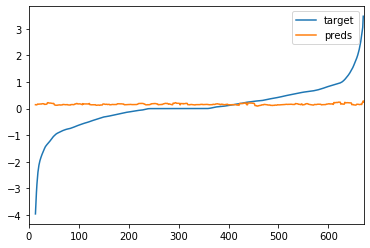

In [220]:
df.sort_values('target').reset_index()[['target', 'preds']].rolling(14).mean().plot()

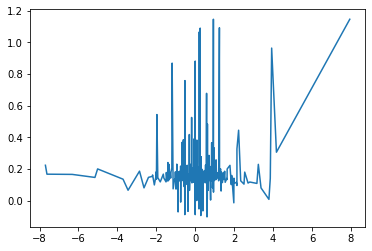

In [210]:
plt.plot(df.sort_values('target').target, df.sort_values('target').preds)

In [191]:
for c in ['preds', 'target']:
    df.loc[df.loc[:, c] > 0, c] = 1
    df.loc[df.loc[:, c] < 1, c] = 0

In [195]:
confusion_matrix(df.target[:-1].astype(int), df.preds[:-1].astype(int))

array([[  6, 351],
       [  6, 308]])

In [196]:
tn, fp, fn, tp = confusion_matrix(df.target[:-1].astype(int), df.preds[:-1].astype(int)).ravel()
(tn, fp, fn, tp)

(6, 351, 6, 308)

In [198]:
df.preds

DTYYYYMMDD
2017-07-27    1.0
2017-07-28    1.0
2017-07-31    1.0
2017-08-01    1.0
2017-08-02    1.0
             ... 
2020-04-02    1.0
2020-04-03    1.0
2020-04-06    1.0
2020-04-07    1.0
2020-04-08    0.0
Name: preds, Length: 672, dtype: float64

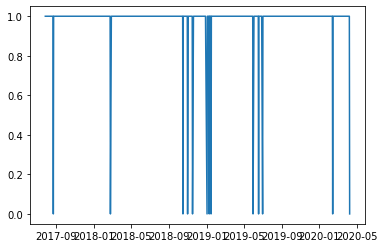

In [197]:
plt.plot(df.preds)

In [ ]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(2)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(2)

df_res_grouped = df_res.drop('zero', axis = 1)

df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3

# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.54

df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])

df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)

df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

df_res_grouped

## Foreign indexes

## Other

### Reports

In [42]:
all_reports = pd.read_csv('../bizcrap/fundamental_reports.csv')

In [61]:
cols_to_change = list(all_reports.columns)
cols_to_change[0] = 'Data'
all_reports.columns = cols_to_change

In [45]:
[a for a in all_reports.name.unique() if 'ORLEN' in a]

['raporty-PKN-ORLEN,Q.html']

In [55]:
cols_zysk = [c for c in all_reports.columns if 'zysk' in c]

In [53]:
for c in all_reports.columns:
    all_reports.loc[all_reports.loc[:,c]==-1,c] = np.nan

In [62]:
all_reports.head()

,Data,name,przychody_ze_sprzedaży_main,przychody_ze_sprzedaży_kk,przychody_ze_sprzedaży_sector,techniczny_koszt_wytworzenia_produkcji_sprzedanej_main,techniczny_koszt_wytworzenia_produkcji_sprzedanej_kk,techniczny_koszt_wytworzenia_produkcji_sprzedanej_sector,koszty_sprzedaży_main,koszty_sprzedaży_kk,...,odpisy_netto_z_tytułu_utraty_wartości_kredytów_sector,ogólne_koszty_administracyjne_main,ogólne_koszty_administracyjne_kk,ogólne_koszty_administracyjne_sector,wynik_operacyjny_main,wynik_operacyjny_kk,wynik_operacyjny_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
0,2011/Q1,"raporty-ROKITA,Q.html",282089.0,NaN,NaN,236690.0,NaN,NaN,16740.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/Q2,"raporty-ROKITA,Q.html",120180.0,-57.40,-6.11,104329.0,-55.92,-7.29,7965.0,-52.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/Q3,"raporty-ROKITA,Q.html",186398.0,55.10,11.93,163713.0,56.92,4.74,10028.0,25.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011/Q4,"raporty-ROKITA,Q.html",232250.0,24.60,24.60,184412.0,12.64,12.64,17560.0,75.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012/Q1,"raporty-ROKITA,Q.html",243002.0,4.63,-7.39,202362.0,9.73,-4.46,13294.0,-24.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
all_reports.loc[all_reports.name=='raporty-PKN-ORLEN,Q.html',['Data', 'name'] + cols_zysk]

,Data,name,zysk_ze_sprzedaży_main,zysk_ze_sprzedaży_kk,zysk_ze_sprzedaży_sector,zysk_operacyjny_(ebit)_main,zysk_operacyjny_(ebit)_kk,zysk_operacyjny_(ebit)_sector,zysk_z_działalności_gospodarczej_main,zysk_z_działalności_gospodarczej_kk,...,zysk_(strata)_netto_z_działalności_zaniechanej_sector,zysk_netto_main,zysk_netto_kk,zysk_netto_sector,zysk_netto_akcjonariuszy_jednostki_dominującej_main,zysk_netto_akcjonariuszy_jednostki_dominującej_kk,zysk_netto_akcjonariuszy_jednostki_dominującej_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
6856,2005/Q1,"raporty-PKN-ORLEN,Q.html",783503.0,NaN,NaN,797953.0,NaN,NaN,820771.0,NaN,...,NaN,678534.0,NaN,NaN,667527.0,NaN,NaN,NaN,NaN,NaN
6857,2005/Q2,"raporty-PKN-ORLEN,Q.html",1101747.0,40.62,11.69,2615077.0,227.72,9.19,2813959.0,242.84,...,NaN,2565468.0,278.09,38.03,2560212.0,283.54,28.11,NaN,NaN,NaN
6858,2005/Q3,"raporty-PKN-ORLEN,Q.html",1120514.0,1.70,37.29,1090777.0,-58.29,29.90,1221227.0,-56.60,...,NaN,994419.0,-61.24,-0.90,985238.0,-61.52,-0.04,NaN,NaN,NaN
6859,2005/Q4,"raporty-PKN-ORLEN,Q.html",673032.0,-39.94,-24.82,443813.0,-59.31,-34.51,417113.0,-65.84,...,NaN,399355.0,-59.84,-1.46,365479.0,-62.90,-3.24,NaN,NaN,NaN
6860,2006/Q1,"raporty-PKN-ORLEN,Q.html",411141.0,-38.91,33.42,450747.0,1.56,39.40,476236.0,14.17,...,NaN,398153.0,-0.30,49.27,364977.0,-0.14,52.20,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,2019/Q1,"raporty-PKN-ORLEN,Q.html",968000.0,86.15,52.80,996000.0,-2.73,31.91,994000.0,2.16,...,NaN,849000.0,37.16,37.16,849000.0,28.25,28.25,NaN,NaN,NaN
6913,2019/Q2,"raporty-PKN-ORLEN,Q.html",1964000.0,102.89,20.46,2086000.0,109.44,52.52,2124000.0,113.68,...,NaN,1601000.0,88.57,62.23,1602000.0,88.69,56.36,NaN,NaN,NaN
6914,2019/Q3,"raporty-PKN-ORLEN,Q.html",1975000.0,0.56,1.69,1807000.0,-13.37,-13.37,1567000.0,-26.22,...,NaN,1266000.0,-20.92,-20.92,1266000.0,-20.97,-23.19,NaN,NaN,NaN
6915,2019/Q4,"raporty-PKN-ORLEN,Q.html",919000.0,-53.47,-16.94,673000.0,-62.76,-32.94,866000.0,-44.74,...,NaN,771000.0,-39.10,-19.55,772000.0,-39.02,-21.16,NaN,NaN,NaN
